In [1]:
import torch
import torch.nn as nn
from torchvision import transforms, datasets, models
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#define model classes
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        out = self.linear(x)
        return out

class FeedforwardNeuralNetModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(FeedforwardNeuralNetModel, self).__init__()
        #linear function
        self.fc1 = nn.Linear(input_size, hidden_size)
        #non-linear function
        self.sig = nn.Sigmoid()
        #linear function (readout)
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        #linear function
        out = self.fc1(x)
        #non-linear
        out = self.sig(out)
        #linear function (readout)
        out = self.fc2(out)
        return out

class CNN_Model(nn.Module):
    def __init__(self):
        super(CNN_Model, self).__init__()

        #convolution 1
        self.cnn1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=1, padding=3)
        self.relu1 = nn.ReLU()

        #Pooling 1
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)

        #convolution 2
        self.cnn2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5,  stride=1, padding=2)
        self.relu2 = nn.ReLU()

        #Pooling 2
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)

        #fully Connected 1 (readout)
        self.fc1 = nn.Linear(128 * 56 * 56, 4)

    def forward(self, x):
        #conv 1
        out = self.cnn1(x)
        out = self.relu1(out)

        #Pooling 1
        out = self.maxpool1(out)

        #conv 2
        out = self.cnn2(out)
        out = self.relu2(out)

        #Pooling 2
        out = self.maxpool2(out)

        #Resize
        '''
        current size: (20, 128, 56, 56) --20 immages per batch, each image is now 128 x 56 x 56 after conv and pooling
        out.size(0): 20
        New out size: (20, 128*56*56)
        '''
        out = out.view(out.size(0), -1)            
        #readout
        out = self.fc1(out)
        return out

In [3]:
data_transforms = transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
    
#identify test dataset
test_dataset = datasets.ImageFolder(root='Images/testing/', transform=data_transforms)
#instantiate dataset loader
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=10, shuffle=False, num_workers=4)#
#get class names from dataset
class_names = test_dataset.classes

In [4]:
#create lists of models, model states to load, and figure titles for plotting and exporting
models = [LogisticRegressionModel(3*224*224, 4), 
          FeedforwardNeuralNetModel(3*224*224, 100, 4), 
          CNN_Model(), 
          models.resnet101(pretrained=False, num_classes = 4)]

model_states = ['Saved_Models\\PhotoClass_Logreg_Model.pkl',
                'Saved_Models\\PhotoClass_FF_NerualNet_Model.pkl', 
                'Saved_Models\\PhotoClass_Simple_CNN_Model.pkl',
                'Saved_Models\\PhotoClass_ResNet101_TL.pkl']

figure_titles = ['Logistic Regression', 'Feed Forward Neural Net', 'Simple Convolutional NN', 'ResNet 101']
figure_names = ['predictions/log_reg.png', 'predictions/ff_nn.png', 
                'predictions/Simple_CNN.png', 'predictions/ResNet.png']

LogisticRegressionModel
['animals', 'animals', 'landscape', 'landscape', 'people', 'people', 'people', 'plants', 'plants', 'plants']
['plants', 'landscape', 'landscape', 'landscape', 'people', 'people', 'people', 'landscape', 'plants', 'plants']
7


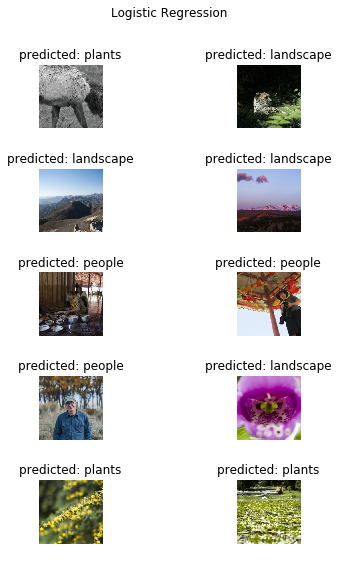

----------
FeedforwardNeuralNetModel
['animals', 'animals', 'landscape', 'landscape', 'people', 'people', 'people', 'plants', 'plants', 'plants']
['landscape', 'plants', 'landscape', 'landscape', 'people', 'animals', 'people', 'people', 'plants', 'plants']
6


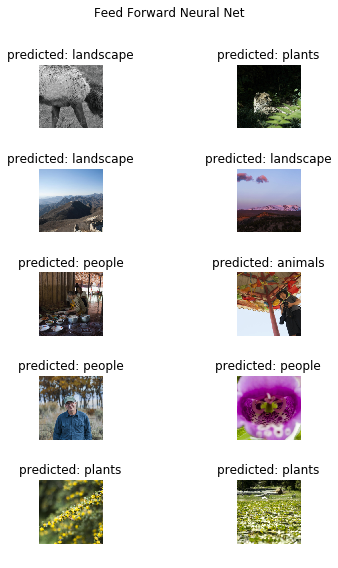

----------
CNN_Model
['animals', 'animals', 'landscape', 'landscape', 'people', 'people', 'people', 'plants', 'plants', 'plants']
['people', 'people', 'people', 'people', 'people', 'plants', 'people', 'people', 'people', 'people']
2


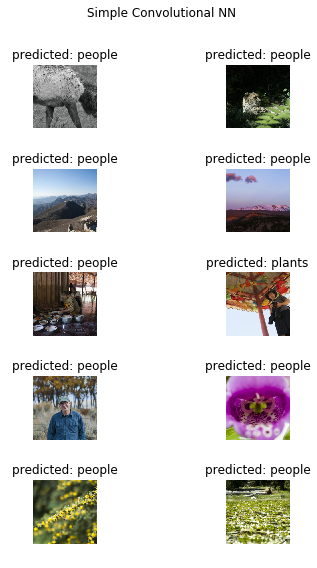

----------
ResNet
['animals', 'animals', 'landscape', 'landscape', 'people', 'people', 'people', 'plants', 'plants', 'plants']
['animals', 'animals', 'landscape', 'landscape', 'people', 'people', 'people', 'plants', 'plants', 'plants']
10


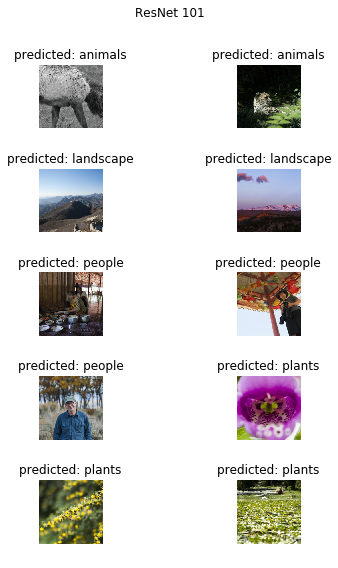

----------


In [5]:
#loop over each model, load saved weights, evaluate test images, plot images with predicted labels
models_2d = ['LogisticRegressionModel', 'FeedforwardNeuralNetModel']

for model, state, fig_title, fig_name in zip(models, model_states, figure_titles, figure_names):
    print(model.__class__.__name__)
    model.load_state_dict(torch.load(state))
    model.eval()
    correct = 0
    for images, labels in test_loader:
        img_labels = [class_names[lbl] for lbl in labels]

        if model.__class__.__name__ in models_2d:
            #need to reshape images for log reg and FF model
            images_trans = images.view(-1, 3*224*224)
            output = model(images_trans)
        else:                
            output = model(images)
        _, predicted = torch.max(output.data, 1)

        correct += (predicted == labels).numpy().sum()

        pred_labels = [class_names[pred] for pred in predicted]

        images_so_far = 0
        fig = plt.figure(figsize=(6, 8))
        for j in range(images.size()[0]):
            images_so_far += 1
            ax = plt.subplot(5, 2, images_so_far)
            inp = images.data[j].numpy().transpose((1, 2, 0))
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            inp = std * inp + mean
            inp = np.clip(inp, 0, 1)
            ax.imshow(inp)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(class_names[predicted[j]]))


        fig.suptitle(fig_title)    
        plt.tight_layout()    
        fig.subplots_adjust(top=0.88)
        
        #print true labels, predicted labels and number correct
        print(img_labels)
        print(pred_labels)
        print(correct)
        plt.show()
        print('-'*10)